In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import pickle
from multiprocessing import Pool
from tqdm import tqdm

# Prepare data

* Attributed rate: how attribution is distributed in combinations
* Click counts: how clicks are distributed in combinations
* Rolling click counts: how clicks are distributed in combinations in sliding windows

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
res_hdf_path = '../derived_data/feats_pile.hdf'

In [4]:
%%time
dat = pd.read_hdf(hdf_path, key='train')

CPU times: user 428 ms, sys: 4.88 s, total: 5.31 s
Wall time: 20.4 s


In [5]:
dat.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [6]:
train = dat.loc[(dat.click_time >= '2017-11-08 04:00:00') & (dat.click_time < '2017-11-08 15:00:00')].copy()

In [7]:
valid = dat.loc[(dat.click_time >= '2017-11-09 04:00:00') & (dat.click_time < '2017-11-09 15:00:00')].copy()

In [8]:
del dat

In [9]:
gc.collect()

91

In [10]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [11]:
feats2comb = ['ip', 'app', 'device', 'os', 'channel']

In [12]:
def get_all_comb_feats(feats2comb, n=None):
    if n is None:
        n = len(feats2comb)
    res = []
    for i in range(n):
        for comb_feats in combinations(feats2comb, i+1):
            res.append(list(comb_feats))
    return res

In [13]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
def choose_int_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'

In [14]:
def get_label_count(args):
    gp = args[0].groupby(args[1], sort=False).size()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_count'})
    gc.collect()
    return gp

In [15]:
def get_label_cumcount(args):
    gp = args[0].groupby(args[1], sort=False).cumcount()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_cumcount'})
    gc.collect()
    return gp

In [16]:
time_win = '30min'

In [92]:
def rolling_sum(df):
    return df.set_index('click_time').rolling(time_win).sum()

def get_label_rolling_sum(args):
    feats = ['click_time'] + args[1]
    gp = args[0].groupby(feats, sort=False).size()
    gp = gp.reset_index().groupby(args[1], sort=False)[['click_time', 0]].apply(rolling_sum)
    gp.loc[:, 0] = gp.loc[:, 0].astype('float16')
    gp = gp.rename(columns={0: '_'.join(args[1]) + '_rolling_sum'})
    gc.collect()
    return gp

In [18]:
def rolling_count(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).count()

def get_label_rolling_count(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_count)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_count'})
    gc.collect()
    return gp

In [19]:
def rolling_max(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).max()

def get_label_rolling_max(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_max)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_max'})
    gc.collect()
    return gp

In [20]:
def rolling_min(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).min()

def get_label_rolling_min(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_min)
    gp = gp.astype(choose_int_type(gp.min()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_min'})
    gc.collect()
    return gp

In [21]:
def rolling_mean(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).mean()

def get_label_rolling_mean(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_mean)
    gp = gp.astype('float16')
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_mean'})
    gc.collect()
    return gp

In [22]:
def rolling_std(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).std()

def get_label_rolling_std(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_std)
    gp = gp.astype('float16')
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_std'})
    gc.collect()
    return gp

In [105]:
def get_labels(function, all_comb_feats):
    print(pd.datetime.now())
    aggs = []
    with Pool(processes=8) as pool:
        for dist in pool.imap_unordered(function, all_comb_feats):
            aggs.append(dist.copy())
            gc.collect()
    return aggs

In [101]:
def merge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_on=dist.index.names, right_index=True, how='left')
    return df

In [25]:
def cummerge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_index=True, right_index=True, how='left')
    return df

In [97]:
all_comb_feats = get_all_comb_feats(feats2comb, 1)

In [98]:
len(all_comb_feats)

5

In [99]:
train_all_comb_feats =[(train, comb_feat) for comb_feat in all_comb_feats]
                  # [['hour'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['minute'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['day_section'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['in_test_hh', 'day_section'] + comb_feat for comb_feat in all_comb_feats])

In [29]:
valid_all_comb_feats =[(valid, comb_feat) for comb_feat in all_comb_feats]

In [103]:
def process(df, all_comb_feats, to_get):
    print('Adding hour...')
    df.loc[:, 'hour'] = df.click_time.dt.hour.astype('uint8')
    print('Adding minute...')
    df.loc[:, 'minute'] = df.hour.astype('uint16') * 60 + df.click_time.dt.minute.astype('uint16')
    print('Adding in_test_hh')
    df.loc[:, 'in_test_hh'] = (
        3 - 2*df.hour.isin(most_freq_hours_in_test_data) -
        1*df.hour.isin(least_freq_hours_in_test_data)
    ).astype('uint8')
    print('Adding day_section...')
    df.loc[:, 'day_section'] = (df.hour // 6).astype('uint8')
    if to_get == 'cumcounts':
        print('Getting cummulative counts...')
        df_counts = get_labels(get_label_cumcount, all_comb_feats)
        print('Cummulative Merging...')
        df = cummerge(df, df_counts)
    else:
        if to_get == 'count':
            print('Getting count...')
            df_counts = get_labels(get_label_count, all_comb_feats)
        elif to_get == 'rolling_count':
            print('Getting rolling count...')
            df_counts = get_labels(get_label_rolling_count, all_comb_feats)
        elif to_get == 'rolling_sum':
            print('Getting rolling sum...')
            df_counts = get_labels(get_label_rolling_sum, all_comb_feats)
        elif to_get == 'rolling_max':
            print('Getting rolling max...')
            df_counts = get_labels(get_label_rolling_max, all_comb_feats)
        elif to_get == 'rolling_min':
            print('Getting rolling min...')
            df_counts = get_labels(get_label_rolling_min, all_comb_feats)
        elif to_get == 'rolling_mean':
            print('Getting rolling mean...')
            df_counts = get_labels(get_label_rolling_mean, all_comb_feats)
        elif to_get == 'rolling_std':
            print('Getting rolling std...')
            df_counts = get_labels(get_label_rolling_std, all_comb_feats)
        print('Merging...')
        df = merge(df, df_counts)
    
    gc.collect()
    return df

In [ ]:
train_all

In [94]:
to_get = 'rolling_sum'

In [106]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,minute,in_test_hh,day_section
82259195,58991,12,1,26,259,2017-11-08 04:00:00,0,4,240,1,0
82259196,184626,18,1,19,121,2017-11-08 04:00:00,0,4,240,1,0
82259197,151871,3,1,9,280,2017-11-08 04:00:00,0,4,240,1,0
82259198,4180,3,1,19,424,2017-11-08 04:00:00,0,4,240,1,0
82259199,231270,9,1,15,466,2017-11-08 04:00:00,0,4,240,1,0


In [107]:
%%time
train = process(train, train_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting rolling sum...
2018-04-19 13:42:12.316003


Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/mul

KeyboardInterrupt: 

In [33]:
%%time
valid = process(valid, valid_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting rolling mean...
2018-04-19 11:48:05.966697


Process ForkPoolWorker-12:
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/indexes/datetimelike.py", line 399, in take
    return self[maybe_slice]
Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-11:
  File "<ipython-input-21-6343438f49f9>", line 5, in get_label_rolling_mean
    gp = args[0].groupby(args[1], sort=False).apply(rolling_mean)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 716, in apply
    return self._python_apply

  File "<ipython-input-21-6343438f49f9>", line 2, in rolling_mean
    return df.groupby('click_time', sort=False).size().rolling(time_win).mean()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 1126, in size
    result = self.grouper.size()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 1764, in size
    ids, _, ngroup = self.group_info
  File "pandas/_libs/src/properties.pyx", line 34, in pandas._libs.lib.cache_readonly.__get__ (pandas/_libs/lib.c:44442)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 1800, in group_info
    comp_ids, obs_group_ids = self._get_compressed_labels()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 1807, in _get_compressed_labels
    all_labels = [ping.labels for ping in self.groupings]
  File "/home/feiz/miniconda3/envs/analys

  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-21-6343438f49f9>", line 5, in get_label_rolling_mean
    gp = args[0].groupby(args[1], sort=False).apply(rolling_mean)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 716, in apply
    return self._python_apply_general(f)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 720, in _python_apply_general
    self.axis)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 1706, in apply
    group_keys = self._get_group_keys()
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/groupby.py", line 1701, in _get_group_keys
    self.labels)
  File "/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/pandas/core/

KeyboardInterrupt: 

In [36]:
%%time
train.to_hdf(res_hdf_path, key=to_get+'_train', model='r+')

CPU times: user 1.65 s, sys: 1.62 s, total: 3.27 s
Wall time: 3.28 s


In [37]:
%%time
valid.to_hdf(res_hdf_path, key=to_get+'_valid', model='r+')

CPU times: user 1.76 s, sys: 1.61 s, total: 3.36 s
Wall time: 3.55 s


In [38]:
gc.collect()

0

In [10]:
train = pd.read_hdf(res_hdf_path, key=to_get+'_train')

In [11]:
valid = pd.read_hdf(res_hdf_path, key=to_get+'_valid')

# Split for training

In [39]:
gc.collect()

0

In [40]:
train.drop(['ip', 'click_time'], axis=1, inplace=True)

In [41]:
valid.drop(['ip', 'click_time'], axis=1, inplace=True)

In [42]:
gc.collect()

14

In [43]:
_, valid = train_test_split(valid, test_size=0.2, stratify=valid.is_attributed)

In [44]:
train.shape

(36475438, 14)

In [45]:
train.is_attributed.value_counts(normalize=True)

0    0.997421
1    0.002579
Name: is_attributed, dtype: float64

In [46]:
valid.shape

(7433836, 14)

In [47]:
valid.is_attributed.value_counts(normalize=True)

0    0.997415
1    0.002585
Name: is_attributed, dtype: float64

# Light GBM

In [48]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'hour', 'minute',
       'in_test_hh', 'day_section', 'app_rolling_mean', 'device_rolling_mean',
       'os_rolling_mean', 'channel_rolling_mean', 'ip_rolling_mean'],
      dtype='object')

In [49]:
target = 'is_attributed'

In [50]:
predictors = train.columns.tolist()

In [51]:
predictors.remove(target)

In [52]:
predictors

['app',
 'device',
 'os',
 'channel',
 'hour',
 'minute',
 'in_test_hh',
 'day_section',
 'app_rolling_mean',
 'device_rolling_mean',
 'os_rolling_mean',
 'channel_rolling_mean',
 'ip_rolling_mean']

In [53]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'in_test_hh', 'day_section']

In [54]:
gc.collect()

20

In [55]:
params = {
    'boosting_type': 'dart',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 10,  # Was 255: Reduced to control overfitting
    'max_depth': -1,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 10,
    'max_bin': 100,
    'subsample': 0.7,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 200
}

In [56]:
dtrain = lgb.Dataset(
    train.loc[:, predictors],
    label=train.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid.loc[:, predictors],
    label=valid.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

In [57]:
del train

In [58]:
del valid

In [59]:
gc.collect()

40

In [60]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None
)

/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.962929	valid's auc: 0.949707
[20]	train's auc: 0.967621	valid's auc: 0.953299
[30]	train's auc: 0.969822	valid's auc: 0.955643
[40]	train's auc: 0.971145	valid's auc: 0.956978
[50]	train's auc: 0.971719	valid's auc: 0.957234
[60]	train's auc: 0.972168	valid's auc: 0.957728
[70]	train's auc: 0.972398	valid's auc: 0.957835
[80]	train's auc: 0.972676	valid's auc: 0.95822


KeyboardInterrupt: 

NameError: name 'lgb_model' is not defined

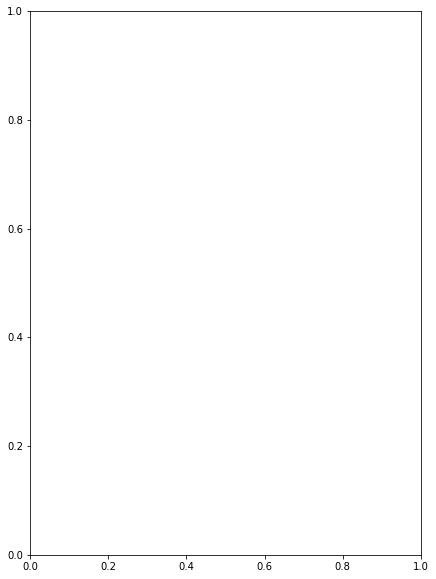

In [61]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [ ]:
import pickle

In [ ]:
with open('../results/{}.pickle'.format(to_get), 'wb') as f:
    pickle.dump(lgb_model, f)

# Create submission

In [ ]:
test = pd.read_hdf(hdf_path, key='test')

In [ ]:
test.head()

In [ ]:
test_all_comb_feats =[(test, comb_feat) for comb_feat in all_comb_feats]

In [ ]:
test = process(test, test_all_comb_feats, to_get)

In [ ]:
test.head()

In [ ]:
pred = lgb_model.predict(test.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [ ]:
test.loc[:, 'is_attributed'] = pred

In [ ]:
test.loc[:, ['click_id', 'is_attributed']].to_csv('../results/{}.csv'.format(to_get), index=False)

In [ ]:
test.loc[:, ['click_id', 'is_attributed']].head()